# <font color='orange'>Course on ADAPTIVE COLLECTIVE SYSTEMS</font>
# <font color='orange'>2. Moran process for evolutionary dynamics</font>

# <font color="green">Cogmaster SUP, 2023-2024</font>

*Teacher: nicolas.bredeche(at)sorbonne-universite.fr*

*Last update: Oct 1st, 2024*


This notebook can be executed in [Google Colab](colab.research.google.com/) or in Jupyter Lab.


# PLEASE FILL IN THE FOLLOWING BEFORE YOU START:

* Student 1: **_JACQUIN__Valentin__22410140_**
* Student 2: **_ISTE__Jerome__71804007_**

This practical course will be evaluated. Please send your notebook to nicolas.bredeche@sorbonne-universite.fr with subject "ACS@CogSUP TP2" before next Monday midnight. I will send you an acknoledgment (if you dont receive anything after 1 week, ask me again without resending the notebook). Good luck!

---
---
---

# <font color='orange'>PREAMBULE: initialization</font>

# Moran Process simulator

The algorithm is as follows:

* Step 1. initialize a population of N individuals. There are n residents (default is n=N-1) and m mutants (default is m=1). Fitness are fixed, the mutants' fitness can be larger (default), smaller or equal to the residents' fitness.
* Step 2. an individual is chosen with a probability proportional to its fitness
* Step 3. another individual is chosen at random for replacement
* Step 4. repeat from Step 2

The important point is that one mutant can replace any another individual (mutant or resident), even if its fitness is lower.

About the implementation used for this practical course: individuals are either residents or mutants, and bear only one trait: blue (=0) for resident, red (=1) for mutant. We will assume here that the mutant's fitness is fixed to 1.1, and the resident fitness is fixed to 1.0. The mutant should have a selective advantage (e.g. on a complete graph with inifinite population).

This cell contains all the necessary functions to run a Moran process. <font color='red'>*This cell **must** be executed before anything else. Unless you modify its content, it is not required to execute it more than once per session.*</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import animation
from IPython.display import HTML, display
from numba import njit  # Import njit from Numba
import time
from datetime import datetime
from datetime import date
from matplotlib import rc
import matplotlib as mpl

# Set up Matplotlib to display animations in the notebook
mpl.rcParams['animation.embed_limit'] = 100  # Set the limit to 100 MB or another larger value
rc('animation', html='jshtml')


G = None
ax = None
pos = None
history = None
adj_matrix = None  # Add adjacency matrix as a global variable
nb_iterations = 0
node_collection = None  # For storing the node collection
title_text = None  # For storing the title text

def init(_nb_nodes, _edges):
    global G, adj_matrix
    G = nx.DiGraph()  # Create a directed graph
    G.add_nodes_from(range(_nb_nodes))
    G.add_edges_from(_edges)
    # Create the adjacency matrix
    adj_matrix = nx.to_numpy_array(G, dtype=np.int32)

def update(num):
    global ax, pos, history, nb_iterations, node_collection, title_text
    if num != 0 and num % (nb_iterations / 10) == 0:
        print(".", end="", flush=True)
    # Update the node colors
    colors = ['blue' if t == 0 else 'red' for t in history[num]]
    node_collection.set_color(colors)
    # Update the title
    title_text.set_text(f'Moran Process - Step {num}')
    # Return the modified artists as a list
    return [node_collection, title_text]

def show(_delay_between_displayed_frames=500):
    global G, ax, history, pos, nb_iterations, node_collection, title_text
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(6, 4))
    pos = nx.spring_layout(G, seed=42)  # Fixed layout for consistency

    print("Rendering Moran process")
    print("__________")

    # Draw the graph once
    colors = ['red' if t == 0 else 'blue' for t in history[0]]
    nodes = list(G.nodes())
    node_collection = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)
    title_text = ax.set_title('Moran Process - Step 0')

    # Create the animation
    ani = animation.FuncAnimation(
        fig,
        update,
        frames=len(history),
        interval=_delay_between_displayed_frames,
        blit=True,  # Enable blitting
        repeat=False
    )
    print()
    # Display the animation
    from matplotlib import rc
    rc('animation', html='jshtml')
    plt.close(fig)  # Prevents duplicate display
    display(ani)

def run_task(_nb_nodes, _edges, _nb_iterations, _types, _delay_between_displayed_frames=500, anim=False):
    global G, ax, pos, history, nb_iterations

    start_time = time.time()

    nb_iterations = _nb_iterations
    nb_nodes = _nb_nodes  # Ensure nb_nodes is defined
    init(nb_nodes, _edges)

    # Initialize the population
    types = _types

    # Define fitness for each type as a NumPy array
    fitness_values = np.array([1.0, 1.1])  # Type B has higher fitness

    # Simulate the Moran process using Numba-compiled function
    history = simulate_moran_process(types, adj_matrix, fitness_values, nb_iterations)
    if anim:
        show(_delay_between_displayed_frames)

    end_time = time.time()
    elapsed_time = end_time - start_time
    if anim:
        print(f"Elapsed time: {elapsed_time:.1f} seconds")

    return history

@njit
def simulate_moran_process(types, adj_matrix, fitness_values, num_iterations, show_progress=False):
    nb_nodes = len(types)
    history = np.empty((num_iterations + 1, nb_nodes), dtype=np.int32)
    history[0] = types.copy()


    if show_progress:
        print("Running Moran process")

    for t in range(1, num_iterations + 1):
      if show_progress and t % (num_iterations // 10) == 0:
          print((t/num_iterations*100),"%")
      fitness_array = fitness_values[types]
      total_fitness = fitness_array.sum()
      reproduction_probs = fitness_array / total_fitness

      # Compute cumulative probabilities for weighted random choice
      cumulative_probs = np.cumsum(reproduction_probs)
      r = np.random.rand()
      reproducer = np.searchsorted(cumulative_probs, r)

      # Choose a neighbor to replace
      neighbors = np.where(adj_matrix[reproducer] == 1)[0]
      if neighbors.size > 0:
          # Randomly select a neighbor uniformly
          idx = np.random.randint(0, neighbors.size)
          replaced = neighbors[idx]
          # Replace the neighbor's type with the reproducer's type
          types[replaced] = types[reproducer]

      history[t] = types.copy()
    return history


#### #### ####

print("\n",date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")



 2024-10-04 11:58:03 GMT
OK.


---
---
---

# <font color='orange'>PART 1: simulating Moran process</font>

- run the two cells below, make sure you understand what is happening.
- analyse the outcome of the two simulations. What do you conclude?

**Methodological hints**:

* *(1) Simulation is stochastic. Run multiple simulations with the same set of parameters to obtain reliable results.*
* *(2) absorbing state may differ. It may not be a good idea to rely on averaged values. Suggestion: a figure can show M different lines, one for each of the M runs (x-axis: iterations, y-axis: number of mutants / population size). This will reveal different regimes, in any (e.g. mutant invades vs. mutant is suppressed).*

**Technical hint**: *history returns a snapshot of the population for each iteration. Use it to create your Figures. For the figures, you may use the code from last lab work, write your own, or use a spreadsheet software. You can also run simulation multiple times and aggregate data in any way you see fit.*

In [2]:
nb_iterations = 100
delay_between_displayed_frames = 50  # in ms


nb_nodes = 10




# 1 is red (mutant), 0 is blue (resident)

In [3]:
y_RandomMutants = []
for run in range(0, 5):
    x = []
    edges = [(i, j) for i in range(nb_nodes) for j in range(nb_nodes) if i != j] # undirected complete graph without self-loops
    types = np.random.choice([0, 1], size=nb_nodes).astype(np.int32) # random distribution of residents and mutants
    history = run_task(nb_nodes, edges, nb_iterations, types, delay_between_displayed_frames)
    for array in history:
        x.append(np.count_nonzero(array == 1))
    y_RandomMutants.append(x)

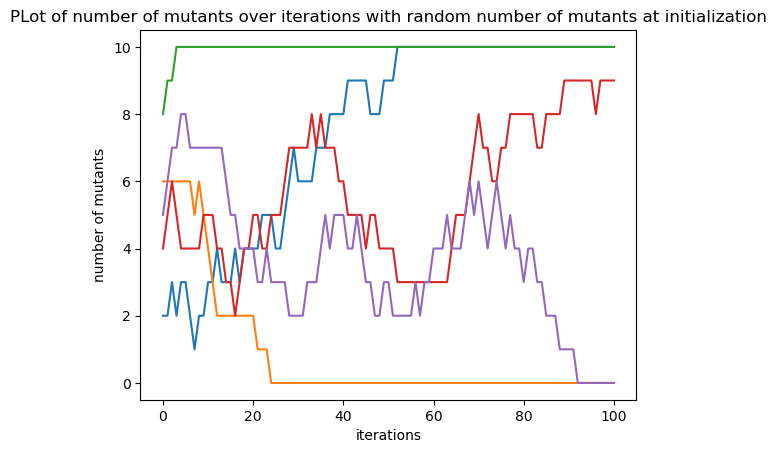

In [4]:
import matplotlib.pyplot as plt
for t in y_RandomMutants:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants')
plt.title('PLot of number of mutants over iterations with random number of mutants at initialization')
plt.show()

In [5]:
nb_iterations = 100
delay_between_displayed_frames = 50  # in ms

nb_nodes = 10


y_1mutants = []
for run in range(0, 5):
    x_1mutants = []
    edges = [(i, j) for i in range(nb_nodes) for j in range(nb_nodes) if i != j] # undirected complete graph without self-loops
    types = np.zeros(nb_nodes, dtype=np.int32) # s
    types[0] = 1 # add a single mutant
    history = run_task(nb_nodes, edges, nb_iterations, types, delay_between_displayed_frames)
    for array in history:
        x_1mutants.append(np.count_nonzero(array == 1))
    y_1mutants.append(x_1mutants)


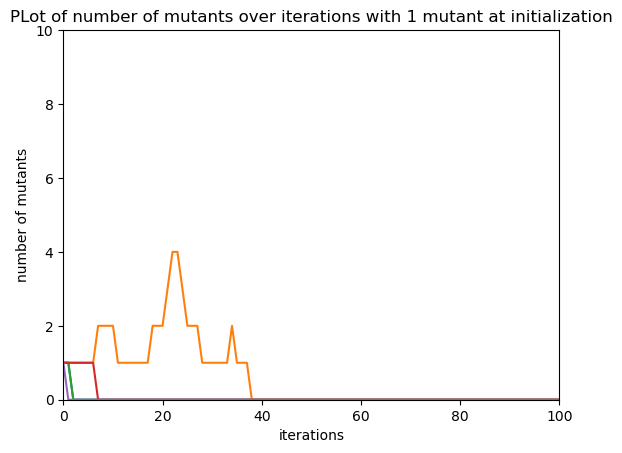

In [6]:
import matplotlib.pyplot as plt
for t in y_1mutants:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants')
plt.ylim(0, 10)
plt.xlim(0, 100)
plt.title('PLot of number of mutants over iterations with 1 mutant at initialization')
plt.show()


Those are simulations of isothermal graphs (i.e. all nodes have the same probability of being replaced)

1) The first graph shows the evolution of the number of mutants, starting with a random number of mutants. It reveals that as the number of initial mutants increases, the tendency of the mutants to spread increases. 

2) In the second graph showing the evolution of the number of mutants, with only one mutant in the beginning.The mutant seems to have a high probability of disappearing in the end, even though it has a higher fitness value than the resident. 

To conclude we observe that even if a mutant has better fitness than the resident, its probability to spread seems linked to the number of mutants in the initialization state.

---
---
---

# <font color='orange'>PART 2: suppressor of selection</font>

Study the two suppressor graphs seen in the lecture's slides, starting with one mutant. Confirm experimentally the probability of fixation. Show a figure with multiple runs (X-axis: iterations, Y-axis: number of mutants / population size).

Explore the sensitivity to the number of nodes.

Fixation probability with suppressive graph:  0.186


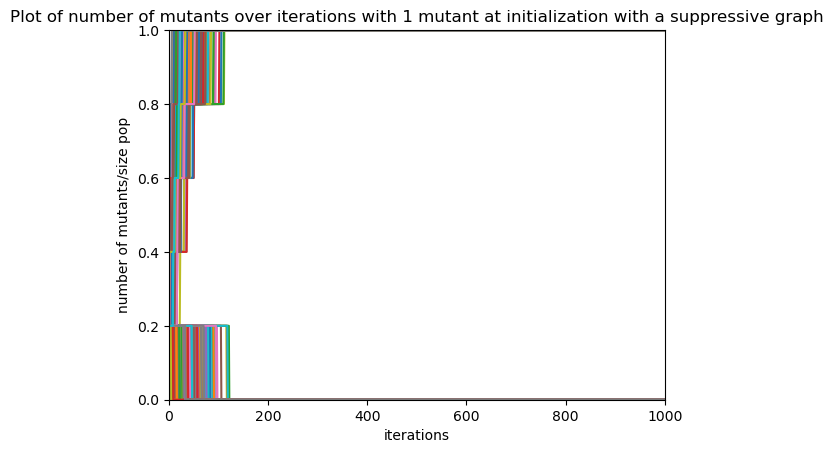

In [7]:
nb_iterations = 1000
delay_between_displayed_frames = 50  # in ms
l_results = []
nb_nodesSupr1 = 5
from random import randint
cptFix = 0
nbrRun = 1000

# Loop over the number of runs
for test in range(0, nbrRun):
    types_F = np.zeros(nb_nodesSupr1, dtype=np.int32)
    types_F[randint(0, nb_nodesSupr1 - 1)] = 1  # Fix the range to be within bounds
    history_F = run_task(nb_nodesSupr1, [(0, i) for i in range(1, nb_nodesSupr1)], nb_iterations, types_F, delay_between_displayed_frames)
    x_F = []
    fixation = False
    # Iteration per Run
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1) / nb_nodesSupr1
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)

import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.title('Plot of number of mutants over iterations with 1 mutant at initialization with a suppressive graph')

print("Fixation probability with suppressive graph: ", cptFix / nbrRun)


Fixation probability with f graph:  0.099


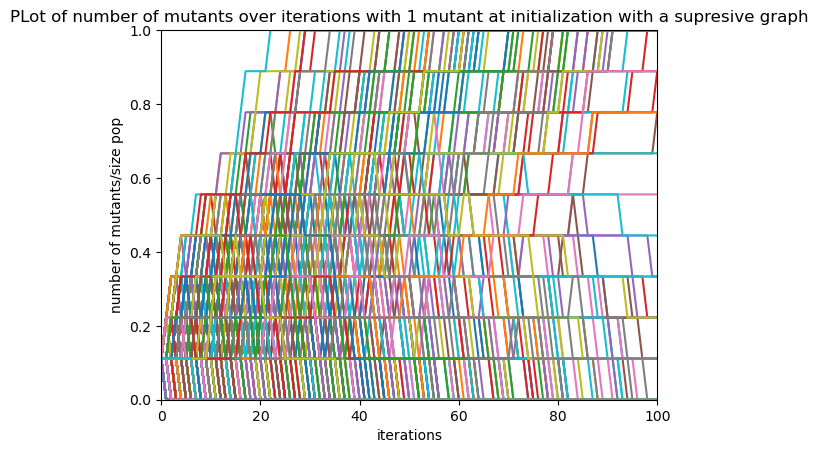

In [8]:
nb_iterations = 100
delay_between_displayed_frames = 50  # in ms
l_results = []
from random import randint
cptFix = 0
nbrRun = 1000
# Loop over the number of runs
for test in range(0, nbrRun):
    types_F = np.zeros(9, dtype=np.int32)
    types_F[randint(0,8)] = 1  # Fix the range to be within bounds
    history_F = run_task(9, [(i - 1, i) for i in range(1,9)], nb_iterations, types_F, delay_between_displayed_frames)
    x_F = []
    fixation = False
    # Iteration per Run
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1)/9
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)
import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.title('PLot of number of mutants over iterations with 1 mutant at initialization with a supresive graph')

print("Fixation probability with f graph: ", cptFix/nbrRun)

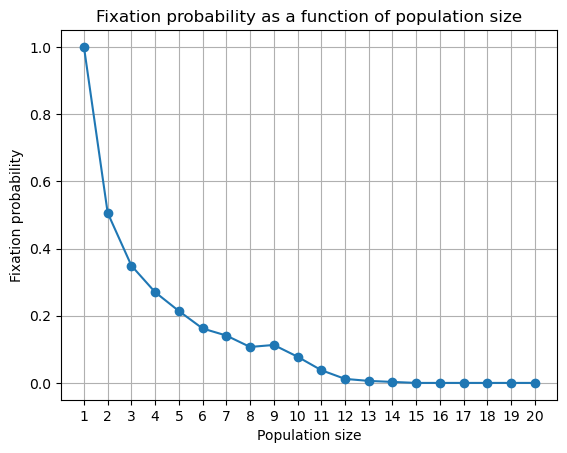

In [9]:
from random import randint

nb_iterations = 100
delay_between_displayed_frames = 50  # in ms
nbrRun = 1000
fixation_probabilities = []

# Loop over different population sizes
for nb_nodes in range(1, 21):
    cptFix = 0
    l_results = []
    # Loop over the number of runs
    for test in range(0, nbrRun):
        types_F = np.zeros(nb_nodes, dtype=np.int32)
        types_F[randint(0, nb_nodes - 1)] = 1  # Fix the range to be within bounds
        history_F = run_task(nb_nodes, [(i - 1, i) for i in range(1, nb_nodes)], nb_iterations, types_F, delay_between_displayed_frames)
        fixation = False
        # Iteration per Run
        for array in history_F:
            nb_mut = np.count_nonzero(array == 1) / nb_nodes
            if nb_mut == 1 and not fixation:
                fixation = True
                cptFix += 1
                break
    fixation_probabilities.append(cptFix / nbrRun)

# Plot the fixation probability as a function of population size
plt.plot(range(1, 21), fixation_probabilities, marker='o')
plt.xlabel('Population size')
plt.ylabel('Fixation probability')
plt.title('Fixation probability as a function of population size')
plt.grid(True)
plt.xticks(range(1, 21, 1))
plt.show()

*Your comments here.*

---
---
---

# <font color='orange'>PART 3: amplifier of selection</font>

Study the amplifier graph "(a)" seen in the lecture's slides, starting with one mutant. Confirm experimentally the probability of fixation. Show a figure with multiple runs (X-axis: iterations, Y-axis: number of mutants / population size).

Propose of an original amplifier graph, not seen in the lecture.

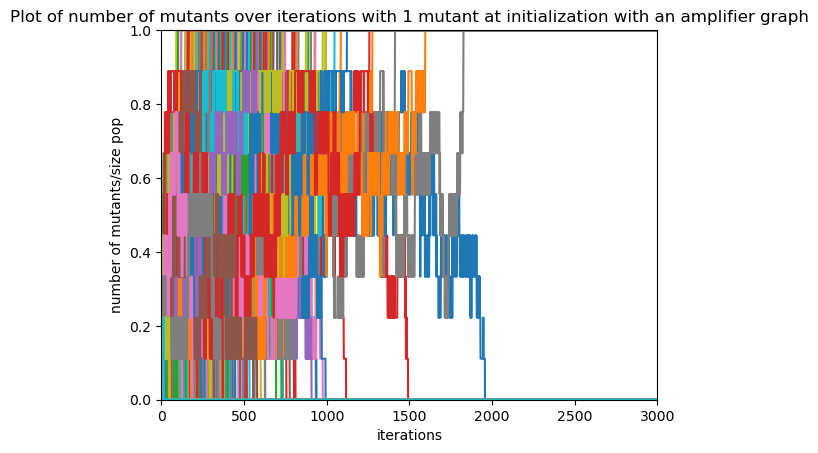

Fixation probability with amplifier graph:  0.198


In [10]:
nb_iterations = 3000
delay_between_displayed_frames = 50  # in ms
l_results = []
cptFix = 0
nbrRun = 1000
nb_nodesAmplifier = 9

for run in range(nbrRun):
    types_F = np.zeros(nb_nodesAmplifier, dtype=np.int32)
    types_F[randint(0, nb_nodesAmplifier - 1)] = 1  # Fix the range to be within bounds
    l_edges = [(0, i) for i in range(1, 9)]
    for i in range(1, nb_nodesAmplifier):
        l_edges.append((i, 0))
    history_F = run_task(nb_nodesAmplifier, l_edges, nb_iterations, types_F, delay_between_displayed_frames, False)
    x_F = []
    fixation = False
    for array in history_F:
        nb_mut = np.count_nonzero(array == 1) / nb_nodesAmplifier
        if nb_mut == 1 and not fixation:
            fixation = True
            cptFix += 1
        x_F.append(nb_mut)
    l_results.append(x_F)

import matplotlib.pyplot as plt
for t in l_results:
    plt.plot(t)
plt.xlabel('iterations')
plt.ylabel('number of mutants/size pop')
plt.ylim(0, 1)
plt.xlim(0, nb_iterations)
plt.title('Plot of number of mutants over iterations with 1 mutant at initialization with an amplifier graph')
plt.show()

print("Fixation probability with amplifier graph: ", cptFix / nbrRun)

Amplifier graph
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 6), (5, 7), (5, 8), (6, 5), (7, 5), (8, 5)]


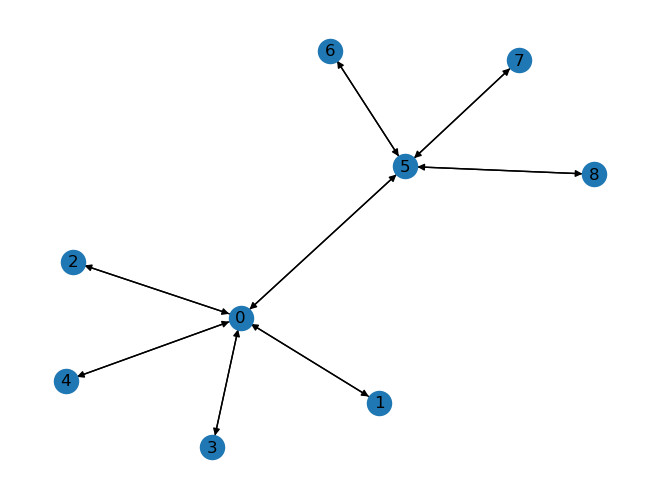

In [11]:
gAmplif = nx.DiGraph()
gAmplif.add_nodes_from(range(9))
gAmplif.add_edges_from([(0, 1), (1, 0), (0, 2), (2, 0), (0,3), (3, 0), (0, 4), (4, 0), (5, 0), (0, 5), (5, 6), (6,5), (5, 7), (7, 5), (5, 8), (8, 5)])
print("Amplifier graph")
print(gAmplif.edges())
nx.draw(gAmplif, with_labels=True)

*Your comments here.*

---
---
---

# <font color='orange'>PART 4: non-standard topology</font>

Study the code. Explore experimentally the probability of fixation of a single mutant. Provide an estimate of fixation time.

Explore the sensitivity to population size (try 50 and 100, each time with two dense clusters and one single link inbetween).

Standard graph
Rendering Moran process
__________


ValueError: 'c' argument has 10 elements, which is inconsistent with 'x' and 'y' with size 20.

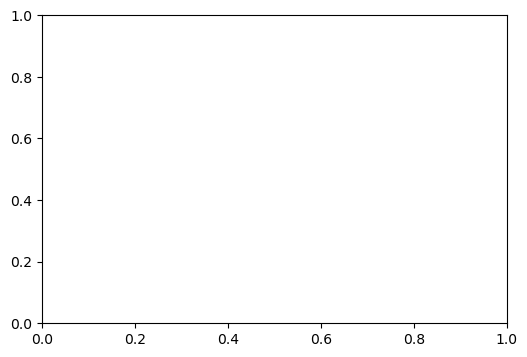

In [13]:
nb_iterations = 10
delay_between_displayed_frames = 50  # in ms


print("Standard graph")
cpt_Fix = 0
history = None  # Reset the history variable
nbr_run = 1
for run in range(0, nbr_run):
    nb_nodes = 20
    edges1 = [(i, i +1) for i in range(0, nb_nodes - 1)] + [(nb_nodes - 1, int(nb_nodes/2))]
    edges1.remove((int(nb_nodes/2) - 1, int(nb_nodes/2)))
    edges1.append((int(nb_nodes/2) - 1, 0))
    edges1.append((0, int(nb_nodes/2)))
    types_Standard = np.array([1, 1, 1, 1, 1, 0, 0 ,0 ,0 ,0], dtype=np.int32)
    history = run_task(nb_nodes, edges1, nb_iterations, types_Standard, delay_between_displayed_frames, anim=True)
    for array in history:
        if np.count_nonzero(array == 1) == nb_nodes:
            cpt_Fix += 1
            break
print("Fixation probability with cycle graph: ", cpt_Fix / nbrRun)
            

print ("Initial population:",history[0])
print ("Final   population:",history[-1])

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of fixation times
plt.hist(l_fix_time, bins=20, edgecolor='black', weights=np.ones(len(l_fix_time)) * 100 / len(l_fix_time))z
plt.xlabel('Number of iterations to fixation')
plt.ylabel('Frequency (%)')
plt.title('Distribution of the number of iterations to reach fixation')
plt.show()

---
---
---

# <font color='orange'>PART 5: characterizing topologies</font>

Consider two topologies:
1. ring: each node is connected to two neighbourgs, forming a closed loop.
2. line: similar to a ring, but with one single missing link.

Explore both topologies (population size of N, one mutant). What can you say about fixation probabilities?

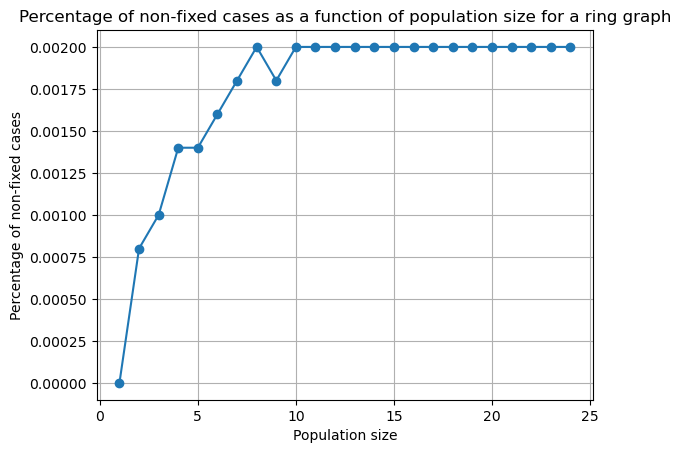

In [17]:
nb_iterations = 100
delay_between_displayed_frames = 50  # in ms


edges_ring = [(i, (i + 1) % nb_nodes) for i in range(nb_nodes)]
l_results = []
l_fix_time = []
l_not_fixed = []
for nb_nodesring in range(1, 25):
    cpt_not_fixed = 0
    for i in range(0, 10):
        types = [0] * nb_nodesring
        types[randint(0, nb_nodesring - 1)] = 1
        types = np.array(types, dtype=np.int32)
        history_ring = run_task(nb_nodesring, edges_ring, nb_iterations, types, delay_between_displayed_frames)
        x_F = []
        added = False
        for index, array in enumerate(history_ring):
            nb_mut = np.count_nonzero(array == 1) / nb_nodesring
            x_F.append(nb_mut)
            if nb_mut == 1 and not added:
                l_fix_time.append(index)
                added = True
        if not added:
            l_fix_time.append(nb_iterations + 100)
            cpt_not_fixed += 1
        l_results.append(x_F)
    cpt_not_fixed = cpt_not_fixed / 5000
    l_not_fixed.append(cpt_not_fixed)


import matplotlib.pyplot as plt
# Plot the percentage of non-fixed cases as a function of population size
plt.plot(range(1, 25), l_not_fixed, marker='o')
plt.xlabel('Population size')
plt.ylabel('Percentage of non-fixed cases')
plt.title('Percentage of non-fixed cases as a function of population size for a ring graph')
plt.grid(True)
plt.show()

In [ ]:
from random import randint

nb_iterations = 100
delay_between_displayed_frames = 50  # in ms
l_results = []
l_fix_time = []
l_not_fixed = []
for nb_nodesring in range(1, 25):
    cpt_not_fixed = 0
    edges_ring = [(i, (i + 1)) for i in range(nb_nodesring)]
    for i in range(0, 10):
        types = [0] * nb_nodesring
        types[randint(0, nb_nodesring - 1)] = 1
        types = np.array(types, dtype=np.int32)
        history_ring = run_task(nb_nodesring, edges_ring, nb_iterations, types, delay_between_displayed_frames)
        x_F = []
        added = False
        for index, array in enumerate(history_ring):
            nb_mut = np.count_nonzero(array == 1) / nb_nodesring
            x_F.append(nb_mut)
            if nb_mut == 1 and not added:
                l_fix_time.append(index)
                added = True
        if not added:
            l_fix_time.append(nb_iterations + 100)
            cpt_not_fixed += 1
        l_results.append(x_F)
    cpt_not_fixed = cpt_not_fixed / 5000
    l_not_fixed.append(cpt_not_fixed)


import matplotlib.pyplot as plt
# Plot the percentage of non-fixed cases as a function of population size
plt.plot(range(1, 25), l_not_fixed, marker='o')
plt.xlabel('Population size')
plt.ylabel('Percentage of non-fixed cases')
plt.title('Percentage of non-fixed cases as a function of population size for a line graph')
plt.grid(True)
plt.show()

*Your comments here.*